# Characterization and Calibration using Graybox

<div class="admonition goal">
    <p class="admonition-title">Goal</p>
    <p>
        This tutorial aims to guide you thourgh a process of characterizing a predicitive model, and using the predictive model in calibrating for quantum gate using open-loop optimization (although not necessary). 
    </p>
</div>

In [1]:
import jax
import jax.numpy as jnp
import inspeqtor.experimental as sq

## Generate some synthetic data

In [2]:
data_model = sq.predefined.get_predefined_data_model_m1()

# Now, we use the noise model to performing the data using simulator.
exp_data, _, _, _ = sq.predefined.generate_experimental_data(
    key=jax.random.key(0),
    hamiltonian=data_model.total_hamiltonian,
    sample_size=100,
    strategy=sq.predefined.SimulationStrategy.SHOT,
    get_qubit_information_fn=lambda: data_model.qubit_information,
    get_control_sequence_fn=lambda: data_model.control_sequence,
    method=sq.predefined.WhiteboxStrategy.TROTTER,
    trotter_steps=10_000,
)

# Now we can prepare the dataset that ready to use.
whitebox = sq.physics.make_trotterization_solver(
    data_model.ideal_hamiltonian,
    data_model.control_sequence,
    data_model.dt,
    trotter_steps=10_000,
)
loaded_data = sq.utils.prepare_data(
    exp_data, data_model.control_sequence, whitebox
)

We can inspect the experiment configuration from predefined noise model using `display` function from `flax.nnx`

In [3]:
from flax.nnx import display

display(loaded_data.experiment_data.experiment_config)

And the experimental data,

In [4]:
loaded_data.experiment_data.postprocessed_data

,parameters_id,expectation_value/+/X,expectation_value/-/X,expectation_value/r/X,expectation_value/l/X,expectation_value/0/X,expectation_value/1/X,expectation_value/+/Y,expectation_value/-/Y,expectation_value/r/Y,...,expectation_value/-/Z,expectation_value/r/Z,expectation_value/l/Z,expectation_value/0/Z,expectation_value/1/Z,expectation_value,initial_state,observable,parameter/0/theta,parameter/0/beta
0,0,0.982,-0.954,0.244,-0.188,-0.042,-0.010,-0.228,0.260,0.934,...,-0.010,0.264,-0.234,0.958,-0.962,0.982,+,X,0.276427,3.608326
1,1,0.998,-0.994,-0.064,0.132,-0.020,0.026,0.084,-0.130,0.442,...,0.054,-0.894,0.886,0.446,-0.486,0.998,+,X,5.154778,2.333456
2,2,0.972,-0.972,0.096,-0.130,0.236,-0.272,-0.106,0.168,-0.580,...,-0.202,-0.774,0.784,-0.590,0.522,0.972,+,X,4.094562,-2.803718
3,3,0.976,-0.978,0.058,-0.052,-0.152,0.190,-0.100,0.038,-0.784,...,0.198,0.574,-0.614,-0.766,0.782,0.976,+,X,2.458046,2.477768
4,4,0.838,-0.826,0.444,-0.414,0.312,-0.310,-0.484,0.438,0.392,...,-0.220,-0.766,0.764,0.540,-0.560,0.838,+,X,5.240611,-4.604616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.992,-0.986,0.148,-0.168,-0.086,0.082,-0.154,0.142,0.472,...,0.076,0.892,-0.896,0.392,-0.474,0.992,+,X,1.112030,-4.666942
96,96,0.972,-0.974,0.226,-0.200,0.010,0.022,-0.212,0.246,0.972,...,-0.070,0.180,-0.148,0.996,-0.992,0.972,+,X,0.119057,-3.652233
97,97,0.976,-0.970,0.204,-0.224,-0.118,0.010,-0.228,0.208,0.900,...,0.054,0.406,-0.420,0.898,-0.906,0.976,+,X,0.430843,3.605063
98,98,1.000,-0.998,0.026,-0.070,0.006,-0.018,-0.028,0.036,0.992,...,-0.030,-0.150,0.158,0.972,-0.978,1.000,+,X,6.077224,1.334615


## Data preprocessing

Since we are going to train Deep neural network, it is considered a good practice to split dataset into training and testing dataset. Here we use a `sq.utils.random_split` helper function for this task.

In [5]:
# Here, we just bundling things up for convinience uses.
key = jax.random.key(0)
key, random_split_key, training_key = jax.random.split(key, 3)
(
    train_control_parameters,
    train_unitaries,
    train_expectation_values,
    test_control_paramaeters,
    test_unitaries,
    test_expectation_values,
) = sq.utils.random_split(
    random_split_key,
    int(loaded_data.control_parameters.shape[0] * 0.1),  # Test size
    loaded_data.control_parameters,
    loaded_data.unitaries,
    loaded_data.expectation_values,
)

We going to pass the data back and forth a lot, so we use a helper `DataBundled` to hold the dataset. The advantange of using this `dataclass` is that we have a code completion.

In [6]:
train_data = sq.optimize.DataBundled(
    control_params=sq.predefined.drag_feature_map(train_control_parameters),
    unitaries=train_unitaries,
    observables=train_expectation_values,
)

test_data = sq.optimize.DataBundled(
    control_params=sq.predefined.drag_feature_map(test_control_paramaeters),
    unitaries=test_unitaries,
    observables=test_expectation_values,
)

Now, we setup the optimizer with the number of epoches.

In [7]:
NUM_EPOCH = 5000
optimizer = sq.optimize.get_default_optimizer(8 * NUM_EPOCH)

In this tutorial, we are going to use predefined $\hat{W}_{O}$-based model using `flax.linen`.

In [8]:
model = sq.models.linen.WoModel(
    hidden_sizes_1=[10],
    hidden_sizes_2=[10],
)
model

WoModel(
    # attributes
    hidden_sizes_1 = [10]
    hidden_sizes_2 = [10]
    pauli_operators = ('X', 'Y', 'Z')
    NUM_UNITARY_PARAMS = 3
    NUM_DIAGONAL_PARAMS = 2
    unitary_activation_fn = <lambda>
    diagonal_activation_fn = <lambda>
)

Next, we also have to make a loss function using `make_loss_fn`. This part depends on the implementation of the model that you choose to use. 

In [9]:
loss_fn = sq.models.linen.make_loss_fn(
    predictive_fn=sq.models.linen.wo_predictive_fn,
    model=model,
    calculate_metric_fn=sq.model.calculate_metric,
    loss_metric=sq.model.LossMetric.MSEE,
)

In [10]:
import optax
from alive_progress import alive_bar

with alive_bar(NUM_EPOCH, title='Training 🚀', force_tty=True) as bar:

    def callback(
        model_params: sq.models.linen.VariableDict,
        opt_state: optax.OptState,
        histories: list[sq.optimize.HistoryEntryV3],
    ):
        bar()

    model_params, opt_state, histories = sq.models.linen.train_model(
        training_key,
        train_data=train_data,
        val_data=test_data,  # Here, we did not care about the validating dataset.
        test_data=test_data,
        model=model,
        optimizer=optimizer,
        loss_fn=loss_fn,
        callbacks=[lambda x, y, z: bar()],
        NUM_EPOCH=NUM_EPOCH,
    )
    # Alternatively, you can use callback for a compact callback function definition.
    # alt_callback_fn = lambda x, y, z: bar() # noqa: E731

Training 🚀 |████████████████████████████████████████| 5000/5000 [100%] in 45.6s


## Save and load model

We can save the model using `ModelData` as follows,

In [11]:
import tempfile
from pathlib import Path

tmpdir = tempfile.TemporaryDirectory()
model_path = Path(tmpdir.name)

# Create the path with parents if not existed already
model_path.mkdir(parents=True, exist_ok=True)

model_state = sq.model.ModelData(
    params=model_params,
    config={
        "hidden_sizes_1": model.hidden_sizes_1,
        "hidden_sizes_2": model.hidden_sizes_1,
    },
)
# Save with,
model_state.to_file(model_path / "model.json")
# and load it back using,
model_state_from_file = sq.model.ModelData.from_file(model_path / "model.json")
tmpdir.cleanup()


We can check that both are equal,

In [12]:
model_state == model_state_from_file

True

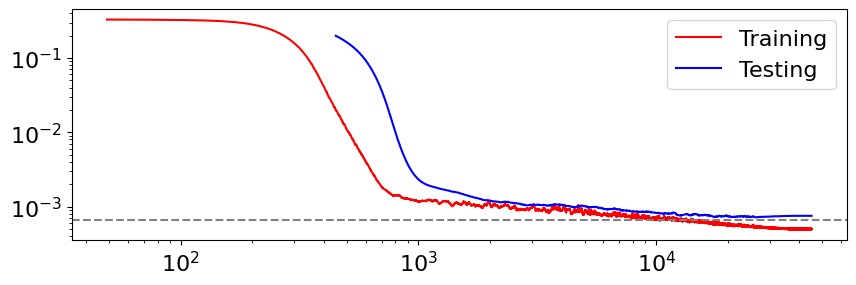

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

hist_df = pd.DataFrame(
    [
        {"step": entry.step, "loss": float(entry.loss), "loop": entry.loop}
        for entry in histories
    ]
)
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
sq.visualization.plot_loss_with_moving_average(
    x=hist_df.query("loop == 'train'")["step"].to_numpy(),
    y=hist_df.query("loop == 'train'")["loss"].to_numpy(),
    ax=ax,
    annotate_at=[],
    color="red",
    label="Training",
)

sq.visualization.plot_loss_with_moving_average(
    x=hist_df.query("loop == 'test'")["step"].to_numpy(),
    y=hist_df.query("loop == 'test'")["loss"].to_numpy(),
    ax=ax,
    annotate_at=[],
    color="blue",
    label="Testing",
)

shots = loaded_data.experiment_data.experiment_config.shots

ax.set_yscale("log")
ax.set_xscale("log")
ax.axhline(y=2/(3 * shots), linestyle='dashed', color="gray")
ax.legend()

sq.visualization.set_fontsize(ax, 16)

## Predictive model construction.

We can use the adapter function that we used to make a loss function with `partial` to create the predictive model.

In [14]:
from functools import partial

model = sq.models.linen.WoModel(**model_state.config)

predictive_model = partial(
    sq.models.linen.wo_predictive_fn, model=model, model_params=model_state.params
)

Here is how can the predictive model be used to predict the expectation values given new parameters.

In [15]:
key, params_key = jax.random.split(key)
_, l2a_fn = sq.control.get_param_array_converter(loaded_data.control_sequence)
sample_params = l2a_fn(loaded_data.control_sequence.sample_params(params_key))

unitary_f = loaded_data.whitebox(sample_params)[-1]
predictive_model(sq.predefined.drag_feature_map(sample_params), unitary_f)

Array([ 0.97084716, -0.97084716,  0.23626797, -0.23626797, -0.04041181,
        0.04041181, -0.22440206,  0.22440206,  0.9390122 , -0.9390122 ,
       -0.26057569,  0.26057569, -0.04353546,  0.04353546,  0.24955875,
       -0.24955875,  0.96738053, -0.96738053], dtype=float64)

Even more elegant, we can define a predictive model with the `whitebox` embeded as follows.

In [16]:
def embed_predictive_model(control_parameters: jnp.ndarray):
    unitary_f = loaded_data.whitebox(control_parameters)[-1]
    return predictive_model(
        sq.predefined.drag_feature_map(control_parameters), unitary_f
    )

embed_predictive_model(sample_params)

Array([ 0.97084716, -0.97084716,  0.23626797, -0.23626797, -0.04041181,
        0.04041181, -0.22440206,  0.22440206,  0.9390122 , -0.9390122 ,
       -0.26057569,  0.26057569, -0.04353546,  0.04353546,  0.24955875,
       -0.24955875,  0.96738053, -0.96738053], dtype=float64)

## Control Calibration

As an example, we are going to use the predictive model to calibrate for the quantum gate. Specifically, we want to find a control parameters that maximize an average gate fidelity with respected to $\sqrt{X}$ gate. First, we define a cost function that the optimizer should find the parameters that minimize its output. 

In [17]:
calculate_agf_sx = sq.physics.direct_AGF_estimation_fn(sq.constant.SX)

@jax.jit
def average_gate_infidelity(params: jnp.ndarray):
    # Predict the expectation values
    predicted_expvals = embed_predictive_model(params)
    # Calculate the average gate fidelity with respected to SX gate.
    AGF = calculate_agf_sx(predicted_expvals)
    # return average gate infidelity squared and log the results.
    return (1 - AGF) ** 2, {"AGF": AGF}

average_gate_infidelity(sample_params)

(Array(0.06409491, dtype=float64), {'AGF': Array(0.74683027, dtype=float64)})

Now, we can optimize it using `sq.optimize.minimize`.

In [18]:
key, init_key = jax.random.split(key)
init_params = l2a_fn(loaded_data.control_sequence.sample_params(init_key))

lower, upper = loaded_data.control_sequence.get_bounds()

optimized_params, aux = sq.optimize.minimize(
    init_params,
    average_gate_infidelity,
    sq.optimize.get_default_optimizer(1000),
    l2a_fn(lower),
    l2a_fn(upper),
    maxiter=1000,
)

|████████████████████████████████████████| 1000/1000 [100%] in 2:09.4 (7.73/s)  


In [56]:
optimized_params

Array([1.93835769, 0.05089961], dtype=float64)

In [58]:
aux[-1]

{'AGF': Array(0.97483661, dtype=float64),
 'params': Array([1.93835769, 0.05089961], dtype=float64)}

## Benchmark

Let's check if the model can accurately characterized the hidden device.

In [63]:
def quantum_device(params: jnp.ndarray):
    return sq.model.get_predict_expectation_value(
        {"X": sq.constant.X, "Y": sq.constant.Y, "Z": sq.constant.Z},
        data_model.solver(params)[-1],
        sq.constant.default_expectation_values_order,
    )

In [66]:
assert isinstance(optimized_params, jnp.ndarray)
real_expvals = quantum_device(optimized_params)

calculate_agf_sx(real_expvals)

Array(0.97310763, dtype=float64)

As a final thought:
- This is the benchmark without taking the finite-shot effect into the account.
- This is characterization without a model selection process such as hyperparameter tuning.